# <center> Gaussian Process & Decision Tree </center>

## Gaussian Process from Sctratch 

Gaussian processes are distribution over functions $f(x)$ of which the distribution is defined by a mean function $m(x)$ and **positive definite** covariance function $k(x,x')$ with $x$ the function values and $(x,x')$ all possible pairs in the input domain:
$$f(x)=GP(m(x),k(x,x'))$$
where for any finite subset $X={x_1, \dots,x_n}$ of domain of $x$, the marginal distribution is a multivariate Gaussian distribution:
$$f(X)=\mathcal{N}(m(X),k(X,X))$$

### 1. Covariance function as prior
To sample functions from the GP, we need to define the mean and covariance functions $k(x_a,x_b)$ that models the joint variability of the GP random variables and returns the modelled covariance between each pair in $x_a$ and $x_b$.

The most common model is the exponentiated quadratic covariance function (also known as the RBF kernel): 
$$k(x_a,x_b)=\exp{\Big(-\frac{1}{2\sigma^2}||x_a-x_b||^2\Big)}

In [17]:
import numpy as np
import scipy.spatial
def RFB_cov(xa,xb):
    sq_norm = -0.5*scipy.spatial.distance.cdist(xa,xb,'sqeuclidean')
    return np.exp(sq_norm)

### 2. Sampling from prior

In [20]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [23]:
# Sample from the Gaussian process distribution
nb_of_samples = 41  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
Σ = RFB_cov(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions)

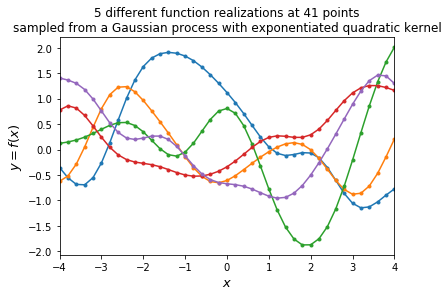

In [24]:
plt.figure(figsize=(6, 4))
for i in range(number_of_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    '5 different function realizations at 41 points\n'
    'sampled from a Gaussian process with exponentiated quadratic kernel'))
plt.xlim([-4, 4])
plt.show()

### 3. Predictions from posterior
We treat the GP as a prior defined by the kernel function and create a posterior distribution given some data. This posterior distribution can then be sued to predict the expected value and probability of the output variable $y$ given input variables $X$. 

Make predictions $y_2=f(X_2)$ for $n_2$ new samples based on GP prior from previously observed $n_1$ sample $(X_1,y_1):
$$p(y_2|y_1,X_1,X_2).$$
1. Write the joint Gaussian is 
$$\begin{bmatrix} y_1\\y_2\end{bmatrix}
\sim\mathcal{N}\Big(\begin{bmatrix}\mu_1\\\mu_2\end{bmatrix},
\begin{bmatrix}\Sigma_{11} & \Sigma_{12}\\\Sigma_{21} & \Sigma_{22}\end{bmatrix}\Big)$$ 
where $\mu_1=m(X_1), \mu_2=m(X_2), \Sigma_{ij}=k(X_i,X_j)$
2. Write the conditional distribution:
$$p(y_2|y_1,X_1,X_2)=\mathcal{N}(\mu_{2|1},\Sigma_{2|1})$$
$$\mu_{2|1}=\mu_2+\Sigma_{21}\Sigma^{-1}_{11}(y_1-\mu_1)$$
$$\Sigma_{2|1}=\Sigma_{22}-\Sigma_{21}\Sigma_{11}^{-1}\Sigma_{12}$$

In [28]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [30]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, RFB_cov)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

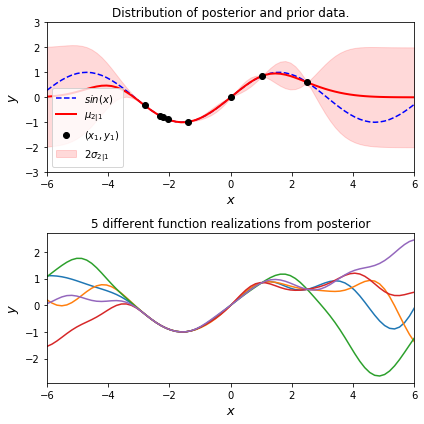

In [31]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()

In [33]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [34]:
np.random.seed(1)
kernel = RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

In [35]:
gp.fit(X1, y1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=10), n_restarts_optimizer=20)

In [38]:
y_pred, sigma = gp.predict(X2, return_std=True)
MSE1 = np.square(np.subtract(y2,y_pred)).mean() 
print(MSE1)
print(np.mean(sigma))

0.765082649097477
0.13957997962168445


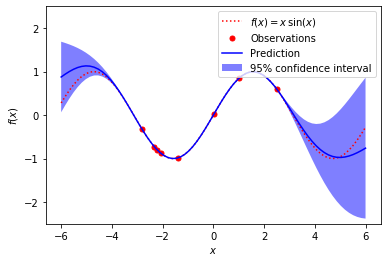

In [44]:
plt.figure()
plt.plot(X2, f_sin(X2), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X1, y1, 'r.', markersize=10, label='Observations')
plt.plot(X2, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([X2, X2[::-1]]),
         np.concatenate([y_pred -  1.9600*sigma,
                        (y_pred +  1.9600*sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-2.5,2.5)
plt.legend()

plt.show()


## Decision Tree Classification

- Two commonly used metrics are:

    - gini impurity: $I_G(f) = \sum_{i=1}^m f_i(1-f_i)$

  - information gain: $I_E(f) = -\sum_{i=1}^m f_i \log_2(f_i)$
  
where $f_i$ is the fraction of items labeled with $i$ in the set and $\sum f_i = 1$.

In [45]:
import pandas as pd
import numpy as np
import math
import  matplotlib.pyplot as plt

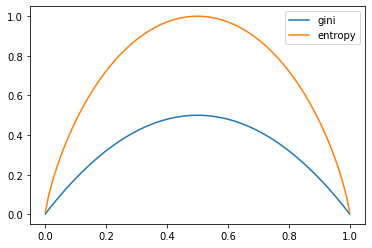

In [46]:
x = np.linspace(start=.001, stop=.999, num=100)  # math.log won't accept 0 or 1
y1 = list(map(lambda i: 2 * i * (1 - i), x))
y2 = list(map(lambda t: -t * math.log(t, 2) - (1 - t) * math.log((1 - t), 2), x))

plt.plot(x, y1, label='gini')
plt.plot(x, y2, label='entropy')
plt.legend(loc=1)
plt.show()

### auto-mpg.data EDA
This demonstration uses the full set of `auto-mpg` data which was used in Decision Tree lecture. As the original data is for a regression problem, there are some EDA required to make it a classification problem.

There are total 8 features and the target `mpg`. Here is the summary of EDA.

1. Make `mpg` **bad** or **good** by labeling 0 or 1, respectively.
2. Make rest features into **low**, **medium**, and **high** by labeling 0, 1, and 2, respectively.
3. Throw **name** since it is not necessary.

In [140]:
filename = "auto-mpg.data"
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']
df = pd.read_csv(filename, delim_whitespace=True, names=column_names)

In [141]:
df.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [142]:
df.isnull().sum() / df.shape[0] * 100.00

mpg             0.0
cylinders       0.0
displacement    0.0
horsepower      0.0
weight          0.0
acceleration    0.0
year            0.0
origin          0.0
name            0.0
dtype: float64

- There are no missing values and therefore we do not need to worry about imputting missing values.

In [143]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

- `horsepower` has to change to continuous value.

In [144]:
df['horsepower']=pd.to_numeric(df['horsepower'],errors='coerce')

- origin is the continent of makers in the example. America is labelled 1, Europe 2, and Asia 3.

In [145]:
df.origin.unique()

array([1, 3, 2])

- Relabel `mpg`. To make this a binary classification, we find the mid-point and make bad for below the mid-point and good above the mid-point.

In [146]:
mpg_cut=(df.mpg.max()+df.mpg.min())/2
print(mpg_cut,df.mpg.max(),df.mpg.min())

27.8 46.6 9.0


In [147]:
df['year']=df['year'].astype(float)
df['mpg'] = pd.cut(df.mpg, bins=[df.mpg.min()-1,mpg_cut,df.mpg.max()], labels=[0,1])

In [148]:
def value_cut(data,feature):
    for feat in feature:
        feat_max=data[feat].max()
        feat_min=data[feat].min()
        feat_cut1=(feat_max+feat_min)/3
        data[feat]=pd.cut(df[feat],bins=[feat_min,feat_cut1,feat_cut1*2,feat_max],labels=[0,1,2])
        print(feat,":",feat_min,feat_cut1,2*feat_cut1,feat_max)
        
    return data

In [149]:
value_cut(df,['displacement','acceleration','weight','horsepower'])

displacement : 68.0 174.33333333333334 348.6666666666667 455.0
acceleration : 8.0 10.933333333333332 21.866666666666664 24.8
weight : 1613.0 2251.0 4502.0 5140.0
horsepower : 46.0 92.0 184.0 230.0


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,0,8,1,1,1,1,70.0,1,chevrolet chevelle malibu
1,0,8,2,1,1,1,70.0,1,buick skylark 320
2,0,8,1,1,1,1,70.0,1,plymouth satellite
3,0,8,1,1,1,1,70.0,1,amc rebel sst
4,0,8,1,1,1,0,70.0,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,0,4,0,0,1,1,82.0,1,ford mustang gl
394,1,4,0,0,0,2,82.0,2,vw pickup
395,1,4,0,0,1,1,82.0,1,dodge rampage
396,1,4,0,0,1,1,82.0,1,ford ranger


- displacement, horsepower, weight, and acceleration are categorized as 0, 1, and 2.

In [150]:
yearmin=df.year.min()
yearmax=df.year.max()
x=(yearmax-yearmin)/4
print(yearmin,yearmax,x)
yearlist=[yearmin-1,yearmin+4,yearmin+8,yearmax]
print(yearlist)

70.0 82.0 3.0
[69.0, 74.0, 78.0, 82.0]


In [151]:
df['year'] = pd.cut(df.year, bins=yearlist, labels=[0,1,2])

We can calculate Gini Index to find which feature is appropriate to split first.

- We find that cylinders and year are two highest IG.
- Since year has the highest, it is the most appropriate feature to start splitting.

In [152]:
from collections import Counter
import math

def purity(L, metric='gini'):
    total = len(L)
    freq = map(lambda x: float(x) / total, list(Counter(L).values()))
    if metric == 'gini':
        scores = map(lambda x: x * (1 - x), freq)
    elif metric == 'entropy':
        scores = map(lambda x: -x * math.log(x, 2), freq)
    return sum(scores)

In [153]:
for feat in ['cylinders','displacement','horsepower','weight','acceleration','year','origin']:
    L=list(df[feat])
    print(feat,purity(L))

cylinders 0.6256028888159391
displacement 0.5762354485997828
horsepower 0.5580793414307719
weight 0.4478801040377767
acceleration 0.09215676371808797
year 0.6628115451630009
origin 0.5382566096815737


In [154]:
df.groupby(['year','mpg']).count()

cylinders  displacement  horsepower  weight  acceleration  origin  \
year mpg                                                                      
0    0          136           136         132     136           135     136   
     1           16            15          16      15            16      16   
1    0          100           100         100     100           100     100   
     1           28            28          28      28            28      28   
2    0           43            43          41      43            43      43   
     1           75            75          73      75            75      75   

          name  
year mpg        
0    0     136  
     1      16  
1    0     100  
     1      28  
2    0      43  
     1      75

In [155]:
df.groupby(['cylinders','mpg']).count()

displacement  horsepower  weight  acceleration   year  origin  \
cylinders mpg                                                                  
3         0             4.0         4.0     4.0           4.0    4.0     4.0   
          1             NaN         NaN     NaN           NaN    NaN     NaN   
4         0            90.0        85.0    90.0          90.0   90.0    90.0   
          1           113.0       112.0   113.0         114.0  114.0   114.0   
5         0             2.0         2.0     2.0           2.0    2.0     2.0   
          1             1.0         1.0     1.0           1.0    1.0     1.0   
6         0            80.0        79.0    80.0          80.0   80.0    80.0   
          1             4.0         4.0     4.0           4.0    4.0     4.0   
8         0           103.0       103.0   103.0         102.0  103.0   103.0   
          1             NaN         NaN     NaN           NaN    NaN     NaN   

                name  
cylinders mpg         
3         0      4.0  
          1      NaN  
4         0     90.0  
          1    114.0  
5         0      2.0  
          1      1.0  
6         0     80.0  
          1      4.0  
8         0    103.0  
          1      NaN

In [156]:
df.groupby(['acceleration','mpg']).count()

cylinders  displacement  horsepower  weight   year  origin  \
acceleration mpg                                                               
0            0         10.0          10.0        10.0    10.0   10.0    10.0   
             1          NaN           NaN         NaN     NaN    NaN     NaN   
1            0        263.0         263.0       257.0   263.0  263.0   263.0   
             1        116.0         115.0       114.0   115.0  116.0   116.0   
2            0          5.0           5.0         5.0     5.0    5.0     5.0   
             1          3.0           3.0         3.0     3.0    3.0     3.0   

                   name  
acceleration mpg         
0            0     10.0  
             1      NaN  
1            0    263.0  
             1    116.0  
2            0      5.0  
             1      3.0

In [157]:
from sklearn import tree
tree_model = tree.DecisionTreeClassifier()

### Arguments:
- criterion: "gini" or "entropy", corresponding to the criteria of "gini impurity" and "information gain". default = 'gini'.

- max_depth: The maximum depth of the tree. default = None, which means the nodes will be expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

- min_samples_split: The minimum number of samples required to split. default = 2.

- min_samples_leaf : The minimum number of samples required to be at a terminate node. default = 1.

#### Methods:

- fit: Build a decision tree from the training set (X, y).

- predict: Predict class or regression value for X.

- predict_log_proba Predict class log-probabilities of the input samples X.

- predict_proba Predict class probabilities of the input samples X.

- score: Return the mean accuracy on the given test data and labels.

- set_params: Set the parameters of this estimator.

- get_params: Get parameters for this estimator.

#### Attributes:

- tree_: Tree object, the underlying tree object.

- feature_importances_: The feature importances. The higher, the more important the feature. Also known as gini importance.

In [160]:
df=df.iloc[:,0:7]
df = df.dropna()

In [161]:
df=df.iloc[:,0:7]

tree_model.fit(df.iloc[:,1:7], df.mpg)

DecisionTreeClassifier()

In [162]:
print(list(df.iloc[:,1:7].columns))
print(tree_model.feature_importances_)

['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']
[0.02068372 0.09067808 0.0238121  0.59045768 0.00648725 0.26788117]


In [163]:
import sklearn.model_selection as model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(df.iloc[:,1:7], df.mpg, train_size=0.8,test_size=0.2)

In [164]:
tree_model.fit(x_train, y_train)
train_error = (1 - tree_model.score(x_train, y_train))
test_error = (1 - tree_model.score(x_test, y_test))
print("The training error is: %.5f" %train_error)
print("The test error is: %.5f" %test_error)

The training error is: 0.10032
The test error is: 0.07692


In [165]:
feature_importance = tree_model.feature_importances_
print([t[1] for t in zip(feature_importance, x_train.columns) if t[0]>0])
print(feature_importance)

['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']
[0.07372326 0.01754289 0.02296894 0.63533343 0.00138964 0.24904185]


In [166]:
from sklearn.model_selection import GridSearchCV
grid_para_tree = [{
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
tree_model.set_params(random_state=108)
grid_search_tree = GridSearchCV(tree_model, grid_para_tree, cv=5, scoring='accuracy', n_jobs=-1)
%time grid_search_tree.fit(x_train, y_train)

CPU times: user 1.38 s, sys: 96.3 ms, total: 1.47 s
Wall time: 9.92 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=108),
             n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'min_samples_leaf': range(1, 10),
                          'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
             scoring='accuracy')

In [167]:
print(grid_search_tree.best_params_)
print(grid_search_tree.best_score_)
print(grid_search_tree.score(x_train, y_train))
print(grid_search_tree.score(x_test, y_test))

{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 28}
0.8804336329984135
0.8964401294498382
0.9230769230769231


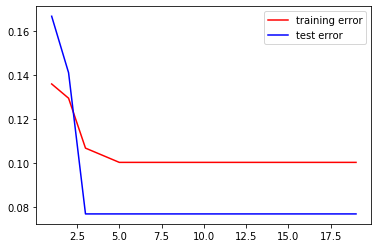

In [169]:
depth = range(1, 20)
train_error = []
test_error = []
for i in depth:
    tree_model.set_params(max_depth=i, min_samples_leaf=1)
    tree_model.fit(x_train, y_train)
    train_error.append(1 - tree_model.score(x_train, y_train))
    test_error.append(1 - tree_model.score(x_test, y_test))

import matplotlib.pyplot as plt
plt.plot(depth, train_error, c='red', label='training error')
plt.plot(depth, test_error, c='blue', label='test error')
#plt.ylim(0.08, 0.35)
plt.legend()
plt.show()

## Decision Tree Regression

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [171]:
hitters = pd.read_csv('Hitters.csv')

In [172]:
hitters.dtypes

AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

In [173]:
hitters.isnull().sum()/hitters.shape[0]*100

AtBat         0.000000
Hits          0.000000
HmRun         0.000000
Runs          0.000000
RBI           0.000000
Walks         0.000000
Years         0.000000
CAtBat        0.000000
CHits         0.000000
CHmRun        0.000000
CRuns         0.000000
CRBI          0.000000
CWalks        0.000000
League        0.000000
Division      0.000000
PutOuts       0.000000
Assists       0.000000
Errors        0.000000
Salary       18.322981
NewLeague     0.000000
dtype: float64

In [174]:
hitters.describe().T

,count,mean,std,min,25%,50%,75%,max
AtBat,322.0,380.928571,153.404981,16.0,255.25,379.5,512.00,687.0
Hits,322.0,101.024845,46.454741,1.0,64.00,96.0,137.00,238.0
HmRun,322.0,10.770186,8.709037,0.0,4.00,8.0,16.00,40.0
Runs,322.0,50.909938,26.024095,0.0,30.25,48.0,69.00,130.0
RBI,322.0,48.027950,26.166895,0.0,28.00,44.0,64.75,121.0
Walks,322.0,38.742236,21.639327,0.0,22.00,35.0,53.00,105.0
Years,322.0,7.444099,4.926087,1.0,4.00,6.0,11.00,24.0
CAtBat,322.0,2648.683230,2324.205870,19.0,816.75,1928.0,3924.25,14053.0
CHits,322.0,717.571429,654.472627,4.0,209.00,508.0,1059.25,4256.0
CHmRun,322.0,69.490683,86.266061,0.0,14.00,37.5,90.00,548.0


In [175]:
cat_cols = [col for col in hitters.columns if hitters[col].dtypes=='O']
num_cols =[col for col in hitters.columns if hitters[col].dtypes != "O" and col not in "Salary"]

In [176]:
q1 = 0.10
q3 = 0.90
for col in num_cols:
    quartile1 = hitters[col].quantile(q1)
    quartile3 = hitters[col].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    if hitters[(hitters[col] > up_limit) | (hitters[col] < low_limit)].any(axis=None):
        hitters.loc[(hitters[col] < low_limit),col] = low_limit
        hitters.loc[(hitters[col] > up_limit), col] = up_limit

In [177]:
# remove outliers for Salary and keep NaN values
salary_up = int(hitters["Salary"].quantile(q3))
hitters = hitters[(hitters["Salary"] < salary_up) | (hitters["Salary"].isnull())]
# data shape after removing outliers in Salary
hitters.shape

(295, 20)

In [178]:
# label encoding of categorical features (League, Division, NewLeague) with two class 
binary_cols = [col for col in hitters.columns if hitters[col].dtype not in [int, float] and hitters[col].nunique() == 2]
for col in binary_cols:
    labelencoder = LabelEncoder()
    hitters[col] = labelencoder.fit_transform(hitters[col])

In [179]:
hitters_drop = hitters.dropna(how='any')

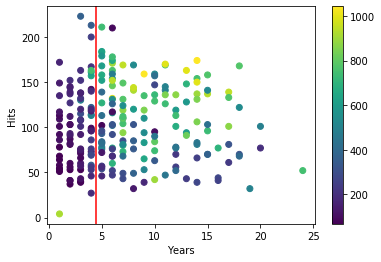

In [180]:
plt.scatter(hitters_drop['Years'],hitters_drop['Hits'],c=hitters_drop['Salary'])
plt.ylabel('Hits')
plt.xlabel('Years')
plt.colorbar()
plt.axvline(x=4.5,color='red')
plt.show()

In [181]:
clf = DecisionTreeRegressor(max_depth = 4)
X=hitters_drop[num_cols]
X = X[['Years','Hits','RBI','Walks','PutOuts']]
y=hitters_drop['Salary']
model = clf.fit(X, y)
X_names = list(X.columns)
y_name = ['Salary']

In [182]:
from sklearn.tree import plot_tree

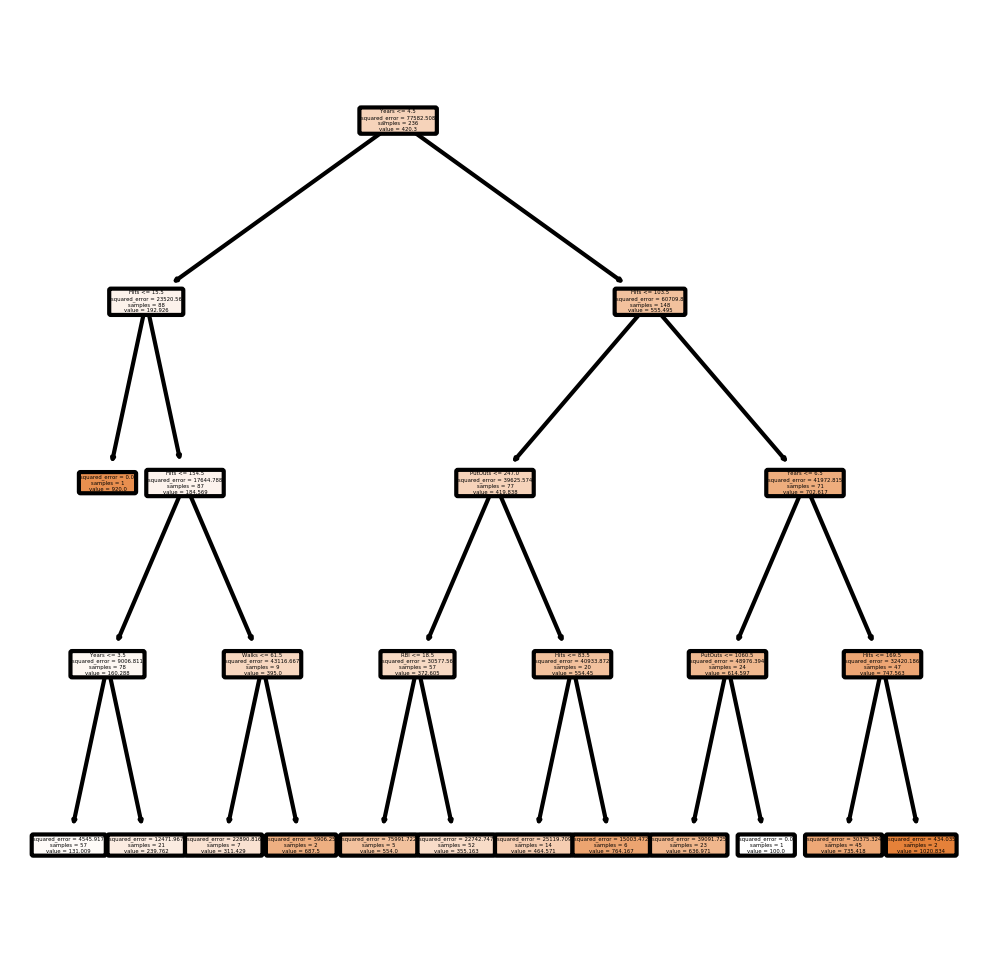

In [183]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
viz=plot_tree(clf, 
          feature_names = X_names, 
          class_names = y_name, 
          filled = True, 
          rounded = True)

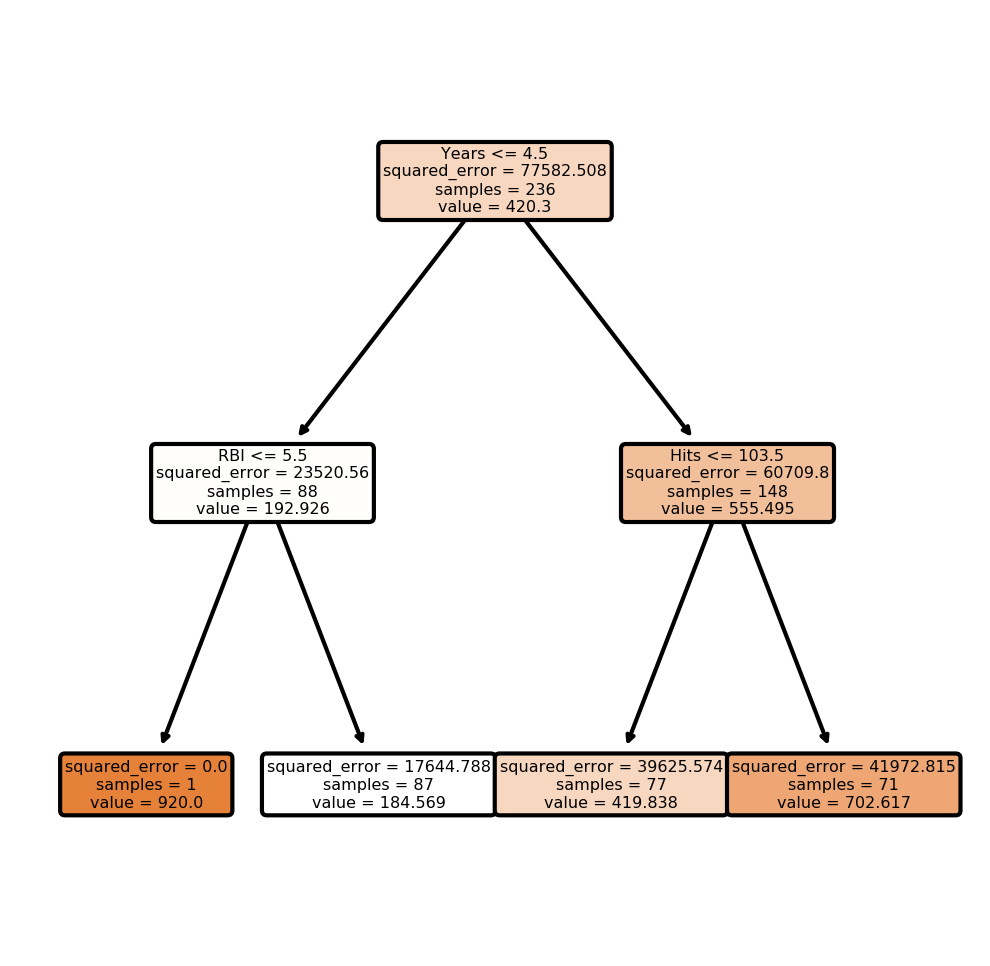

In [184]:
clf = DecisionTreeRegressor(max_depth = 2)
X=hitters_drop[num_cols]
X = X[['Years','Hits','RBI','Walks','PutOuts']]
y=hitters_drop['Salary']
model = clf.fit(X, y)
X_names = list(X.columns)
y_name = ['Salary']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
viz=plot_tree(clf, 
          feature_names = X_names, 
          class_names = y_name, 
          filled = True, 
          rounded = True)

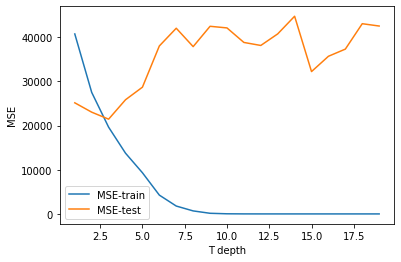

In [185]:
MSE_train_list, MSE_test_list, k_list = [], [], []
from sklearn.model_selection import train_test_split
X=hitters_drop[num_cols]
y=hitters_drop['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
for k in range(1,20):
    clf = DecisionTreeRegressor(max_depth = k)
    
    model = clf.fit(X_train, y_train)
    MSE_train = mean_squared_error(y_train,model.predict(X_train))
    MSE_test = mean_squared_error(y_test,model.predict(X_test))
    k_list.append(k)
    MSE_train_list.append(MSE_train)
    MSE_test_list.append(MSE_test)
plt.figure(facecolor='white')
plt.plot(k_list,MSE_train_list,label='MSE-train')
plt.plot(k_list,MSE_test_list,label='MSE-test')
plt.xlabel('T depth')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [186]:

clf.fit(X_train, y_train)

parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12]}
clf.set_params(random_state=108)
tuning_model=GridSearchCV(clf,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)

In [187]:
tuning_model.fit(X_train,y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV 1/3] END ...max_depth=1, splitter=best;, score=-35468.552 total time=   0.0s
[CV 2/3] END ...max_depth=1, splitter=best;, score=-53337.491 total time=   0.0s
[CV 3/3] END ...max_depth=1, splitter=best;, score=-52282.611 total time=   0.0s
[CV 1/3] END .max_depth=1, splitter=random;, score=-61188.599 total time=   0.0s
[CV 2/3] END .max_depth=1, splitter=random;, score=-43632.730 total time=   0.0s
[CV 3/3] END .max_depth=1, splitter=random;, score=-79190.075 total time=   0.0s
[CV 1/3] END ...max_depth=3, splitter=best;, score=-42264.118 total time=   0.0s
[CV 2/3] END ...max_depth=3, splitter=best;, score=-39806.713 total time=   0.0s
[CV 3/3] END ...max_depth=3, splitter=best;, score=-48403.515 total time=   0.0s
[CV 1/3] END .max_depth=3, splitter=random;, score=-47923.885 total time=   0.0s
[CV 2/3] END .max_depth=3, splitter=random;, score=-31951.954 total time=   0.0s
[CV 3/3] END .max_depth=3, splitter=random;, sco

GridSearchCV(cv=3,
             estimator=DecisionTreeRegressor(max_depth=19, random_state=108),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 12],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error', verbose=3)

In [188]:
print(tuning_model.best_params_)
print(tuning_model.best_score_)


{'max_depth': 3, 'splitter': 'best'}
-43491.44886921732
